In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import itertools
import pandas as pd
import math
from scipy.stats import norm
from scipy.integrate import quad
from scipy.special import erfc
from scipy import fftpack

# import functions

# Funções

# Definições

Todas as portadoras:   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63] 

Portadoras piloto: [ 0  8 16 24 32 40 48 56 63] 

Portadoras de informação:  [ 1  2  3  4  5  6  7  9 10 11 12 13 14 15 17 18 19 20 21 22 23 25 26 27
 28 29 30 31 33 34 35 36 37 38 39 41 42 43 44 45 46 47 49 50 51 52 53 54
 55 57 58 59 60 61 62] 



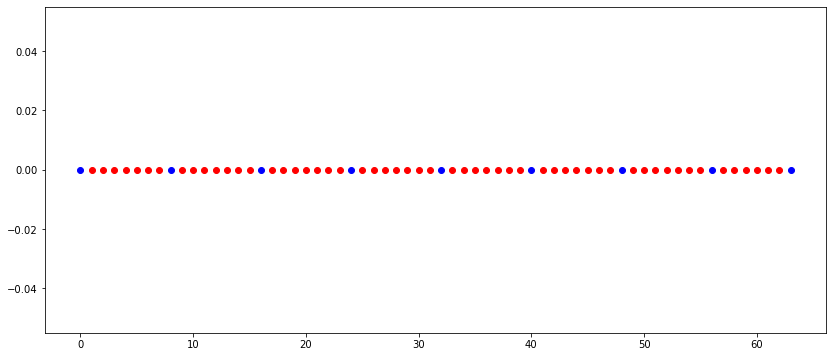

In [2]:
K = 64; # número de subportadoras OFDM
CP = K//4; # comprimento do prefixo cíclico. 25% do tamanho do bloco OFDM; CP-OFDM

P = K//8 # número de subportadoras piloto por símbolo OFDM
pilotValue = 3+3j # a valor de cada subportadora piloto


allCarriers = np.arange(K)  # indices de todas as subportadoras ([0, 1, ... K-1])
pilotCarriers = allCarriers[::K//P] # piloto a cada K//P subportadoras
pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
P = P+1

# portadoras de informação
dataCarriers = np.delete(allCarriers, pilotCarriers)

print ("Todas as portadoras:   %s \n" % allCarriers)
print ("Portadoras piloto: %s \n" % pilotCarriers)
print ("Portadoras de informação:  %s \n" % dataCarriers)

plt.figure(figsize = (14,6))
plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'bo', label = 'piloto')
plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'ro', label = 'informação')

In [29]:
def qam_map(seq_bit, mu):
    
    mapping_table = {}
    mapping_table_index = []
    mu_aux = 0
    seq_bit_aux = 0
    
    for b in range(-(int(math.sqrt(2**mu)) - 1), int(math.sqrt(2**mu)), 2):
        for c in range(-(int(math.sqrt(2**mu)) - 1), int(math.sqrt(2**mu)), 2):
            if mu_aux % 2 == 0:
                mapping_table[seq_bit[seq_bit_aux]] = b + c*1j
                mapping_table_index.append(mapping_table[seq_bit[seq_bit_aux]])
            else:
                mapping_table[seq_bit[seq_bit_aux]] = b - c*1j
                mapping_table_index.append(mapping_table[seq_bit[seq_bit_aux]])
            
            seq_bit_aux += 1
        mu_aux += 1
        
    return mapping_table, mapping_table_index



def xor_c(a, b): 
    return '0' if(a == b) else '1'; 



def binarytoGray(binary): 
    gray = "";   
    gray += binary[0]; # Bit mais significativo é o mesmo em ambos
  
    for i in range(1, len(binary)): 
        gray += xor_c(binary[i - 1], binary[i]); 
  
    return gray;



def binseq(k):
    return [''.join(x) for x in itertools.product('01', repeat=k)]



def SP(bits):
    return bits.reshape((len(dataCarriers), mu))



def Mapping(bits):
    mapping = []
    for b in bits:
        c = np.array_str(b)
        c = c.translate({ord('['):None,ord(']'):None,ord(' '):None})
        mapping.append(mapping_table[c])
    return mapping



def OFDM_symbol(QAM_payload):
    symbol = np.zeros(K, dtype=complex) # todas as K subportadoras
    symbol[pilotCarriers] = pilotValue  # aloca as subportadoras piloto 
    symbol[dataCarriers] = QAM_payload  # aloca as subportadoras de dados
    return symbol



def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)



def addCP(OFDM_time, CP):
    cp = OFDM_time[-CP:]               # pega as últimas amostras do CP ...
    return np.hstack([cp, OFDM_time])  # ... e as adiciona no início dos dados



def channel(signal, type_channel, snr):
#     WIRELESS
    if type_channel == 'wireless':        
        convolved = np.convolve(signal, channelResponse)
        signal_power = np.mean(abs(convolved ** 2))
        sigma2 = signal_power * 10 **(-snr/10)  # potência do ruído

#         print ("RX Potência do sinal: %.8f. Potência do ruído: %.8f" % (signal_power, sigma2))
        
        noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape) + 1j * np.random.randn(*convolved.shape))
        
        return convolved + noise
    
#     AWGN
    elif type_channel == 'awgn':
        SNR = 10 ** (-snr/10)
        signal_power = sum(abs(signal) ** 2)/len(signal) # Potência do sinal
        No = signal_power * SNR # Potência do ruído

#         print ("RX Potência do sinal: %.8f. Potência do ruído: %.8f" % (signal_power, No))
    
        if any(np.iscomplex(s) == False for s in signal):
            noise = np.sqrt(No/2) * np.random.standard_normal(signal.shape)              
        else:
            noise = np.sqrt(No/2) * (np.random.standard_normal(signal.shape) + 1j * np.random.standard_normal(signal.shape))
            
        plt.plot(noise)
        r = signal + noise 
                
        return r
    


def removeCP(signal):
    return signal[CP:(CP+K)]



def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)



def channelEstimate(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers]  #  extrair os valores piloto do sinal RX
    Hest_at_pilots = pilots / pilotValue # divide pelo valor do piloto transmitido; pilotValue = 3 + 3j
    
    # Interpolação entre as portadoras piloto para realizar a estimação do canal nas portadoras de dados
    Hest_abs = interp1d(pilotCarriers, abs(Hest_at_pilots), kind = 'linear')(allCarriers)
    Hest_phase = interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind = 'linear')(allCarriers)
    Hest = Hest_abs * np.exp(1j * Hest_phase)
    
#     plt.plot(allCarriers, abs(H_exact), label = 'Canal correto')
#     plt.stem(pilotCarriers, abs(Hest_at_pilots), label = 'Estimativas piloto')
#     plt.plot(allCarriers, abs(Hest), label = 'Canal estimado via interpolação')
#     plt.grid(True); plt.xlabel('índice da portadora'); plt.ylabel('$|H(f)|$'); plt.legend(fontsize=10)
#     plt.ylim(0,2)
    
    return Hest



def equalize(OFDM_demod, Hest):
    return OFDM_demod / Hest



def get_payload(equalized): # apenas os símbolos OFDM de portadoras de dados
    return equalized[dataCarriers]



def Demapping(QAM_est):
    # pontos da constelação
    constellation = np.array([x for x in demapping_table.keys()])
    
    # calcula a distância entre cada ponto recebido
    dists = abs(QAM_est.reshape((-1,1)) - constellation.reshape((1,-1)))
    
    # para cada elemento no QAM, escolher o índice na constelação
    # que pertence ao ponto de constelação mais próximo        
    const_index = dists.argmin(axis=1) # argmin(axis = 1) porque vai pegar o índice do menor valor em cada linha

    # obter de volta o ponto real da constelação    
    hardDecision = constellation[const_index]

    # converte o símbolo da constelação em sequência de bits
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision



def error_estimation(bits_SP, bits_est):
    erro = 0
    i = 0

    for b in bits_SP:    
        c = np.array_str(b)
        c = c.translate({ord('['):None,ord(']'):None,ord(' '):None})
        if bits_est[i] != c:
            erro += 1
        i += 1
        
    return erro



def prob_symb_error(snr, mu):
    SNR = 10 ** (snr/10)
    if mu == 2:
        Pb = 0.5 * erfc(np.sqrt(SNR))/2
    else:
        Pb = (2/mu) * (1 - 1/np.sqrt(mu)) * erfc(np.sqrt((3*mu*SNR)/(2*((mu**2) - 1))))/mu
    return Pb


### Mapeamento *mu-QAM*

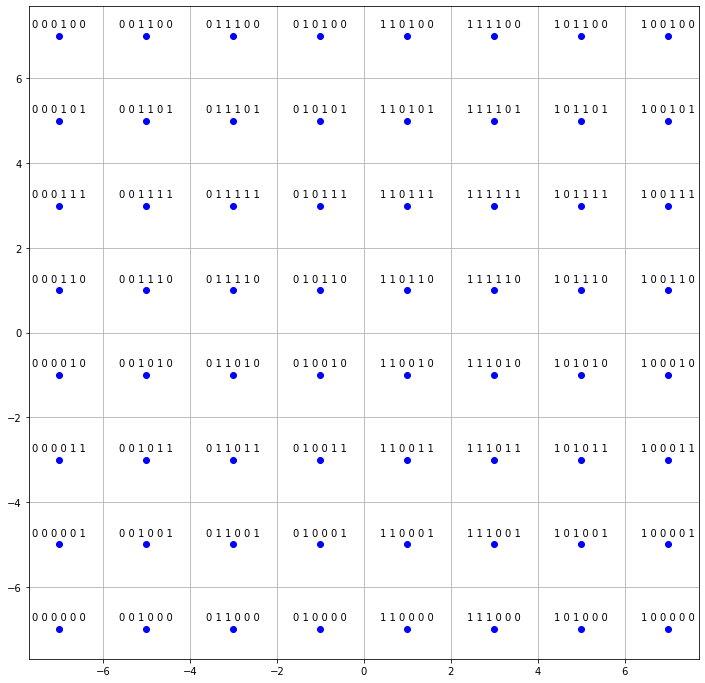

In [4]:
mu = 6 # bits por símbolo (i.e. 16QAM)
seq_bin = binseq(mu)

seq_bin_gray = []
for a in seq_bin:    
    seq_bin_gray.append(binarytoGray(a))
    
mapping_table, mapping_table_index = qam_map(seq_bin_gray, mu)

plt.figure(figsize = (12,12))
plt.grid(True)
for i in range(2**mu):
    seq_bin_gray_label = seq_bin_gray[i]
    plt.plot(mapping_table_index[i].real, mapping_table_index[i].imag, 'bo')
    plt.text(mapping_table_index[i].real, mapping_table_index[i].imag + 0.2, 
             " ".join(seq_bin_gray_label), ha='center')

### Resposta ao impulso de um canal *wireless*

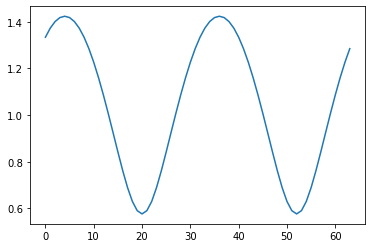

In [5]:
channelResponse = np.array([1, 0, 0.3+0.3j])  # resposta ao impulso de um sinal wireless
H_exact = np.fft.fft(channelResponse, K)
plt.plot(allCarriers, abs(H_exact))
SNR_db = 10

### Geração dos *bits*

In [6]:
payloadBits_per_OFDM = len(dataCarriers) * mu  # número de "bits payload" por símbolo OFDM
bits = np.random.binomial(n = 1, p = 0.5, size = (payloadBits_per_OFDM))
total_bits = len(bits)

print ("Quantidade de bits: ", total_bits)
print ("Primeiros 20 bits: ", bits[:20])

print ("Média de bits (expectativa - em torno de 0.5): ", np.mean(bits))

Quantidade de bits:  330
Primeiros 20 bits:  [0 1 1 0 1 1 0 0 1 1 0 1 1 0 0 0 1 0 1 1]
Média de bits (expectativa - em torno de 0.5):  0.5


### Separação dos *bits* por símbolo OFDM

Os *bits* são convertidos de serial para paralelo, em que os *bits* do quadro OFDM são separados em grupos de **M** *bits*, em que cada grupo é uma subportadora.

In [7]:
bits_SP = SP(bits)

### Mapeamento da sequência dos bits OFDM num símbolo QAM

In [8]:
QAM = Mapping(bits_SP)

print ("Primeiros 5 sequência de bits e símbolos OFDM:")
print (bits_SP[:5])
print (QAM[:5])

Primeiros 5 sequência de bits e símbolos OFDM:
[[0 1 1 0 1 1]
 [0 0 1 1 0 1]
 [1 0 0 0 1 0]
 [1 1 0 1 1 1]
 [0 0 0 0 0 1]]
[(-3-3j), (-5+5j), (7-1j), (1+3j), (-7-5j)]


### Quantidade de subportadoras no domínio da frequência

In [9]:
OFDM_data = OFDM_symbol(QAM)
print ("Número de portadoras OFDM no domínio da frequência: ", len(OFDM_data))

Número de portadoras OFDM no domínio da frequência:  64


<ipython-input-58-6cf10e5e2316>:2: RuntimeWarning: invalid value encountered in true_divide
  return (1/np.sqrt(T))*(np.sin(np.pi*x/T*(1-B))+4*B*x/T*np.cos(np.pi*x/T*(1+B)))/(np.pi*x/T*(1-(4*B*x/T)**2))


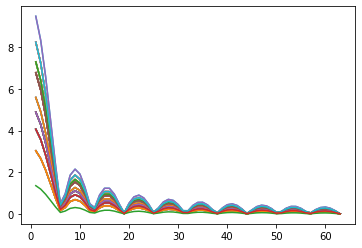

In [79]:
a = RootRaisedCos(t, 0, 1)
for i in allCarriers:
    plt.plot(allCarriers, np.abs(a*OFDM_data[i]))

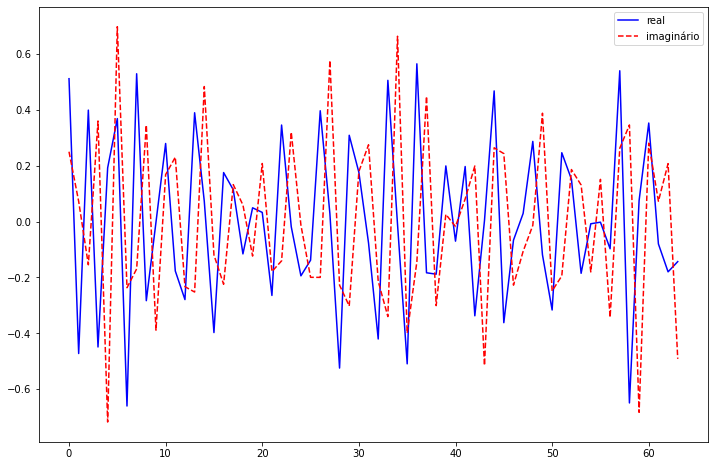

In [67]:
# Teste de plot da IFFT de uma exponencial truncada*símbolos QAM

n = np.zeros((K,), dtype = complex)
n[15:30] = np.exp(1j*np.random.uniform(0, 2*np.pi, (15,)))
s = np.fft.ifft(n*OFDM_data)
plt.figure(figsize = (12,8))
plt.plot(allCarriers, s.real, 'b-', allCarriers, s.imag, 'r--')

plt.legend(('real', 'imaginário'))
plt.show()

### Transformada de Fourier inversa e determinação da quantidade de subportadoras no domínio do tempo antes do CP

In [44]:
OFDM_time = IDFT(OFDM_data)
print ("Número de amostras OFDM no domínio do tempo antes da adição do CP: ", len(OFDM_time))
# print(OFDM_time)

Número de amostras OFDM no domínio do tempo antes da adição do CP:  64


### Quantidade de subportadoras no domínio do tempo após o CP

In [12]:
OFDM_withCP = addCP(OFDM_time, CP)
print ("Número de amostras OFDM no domínio do tempo com CP: ", len(OFDM_withCP))

Número de amostras OFDM no domínio do tempo com CP:  80


### Conversão Paralelo-Serial

In [31]:
OFDM_TX = OFDM_withCP.reshape((-1,))

### Símbolo OFDM na recepção do sistema

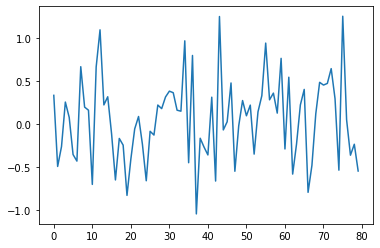

In [30]:
# SNRdb = 20  # SNR no receptor (em dB)
P = []
BER = []
SNR = []
bits_wrong = []

for snr in np.arange(0, 1, 1):
    
    # Implementar formatador de símbolos e CAD
    # doc scipy.signal
    
    OFDM_RX = channel(OFDM_TX, 'awgn', snr)

    OFDM_RX_noCP = removeCP(OFDM_RX)
    
    OFDM_demod = DFT(OFDM_RX_noCP)
    
    Hest = channelEstimate(OFDM_demod)
    
    equalized_Hest = equalize(OFDM_demod, Hest)

    QAM_est = get_payload(equalized_Hest)
    
    demapping_table = {v : k for k, v in mapping_table.items()}
    
    PS_est, hardDecision = Demapping(QAM_est)

    bits_est = PS_est.reshape((-1,))

#     # ------------- Variáveis -------------
    
    SNR.append(snr)
    bits_wrong = error_estimation(bits_SP, bits_est)
    BER.append(bits_wrong/total_bits)
    P.append(prob_symb_error(snr, mu))

(-5.0, 110.0)

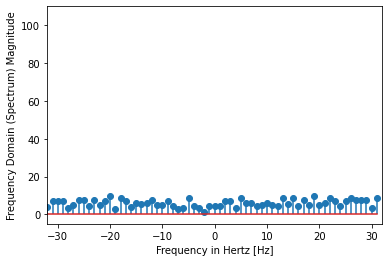

<Figure size 1008x576 with 0 Axes>

In [15]:
X = fftpack.fft(OFDM_RX_noCP)
f_s = K
freqs = fftpack.fftfreq(K) * f_s

fig, ax = plt.subplots()
plt.figure(figsize = (14,8))
ax.stem(freqs, np.abs(X))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(-f_s / 2, f_s / 2)
ax.set_ylim(-5, 110)

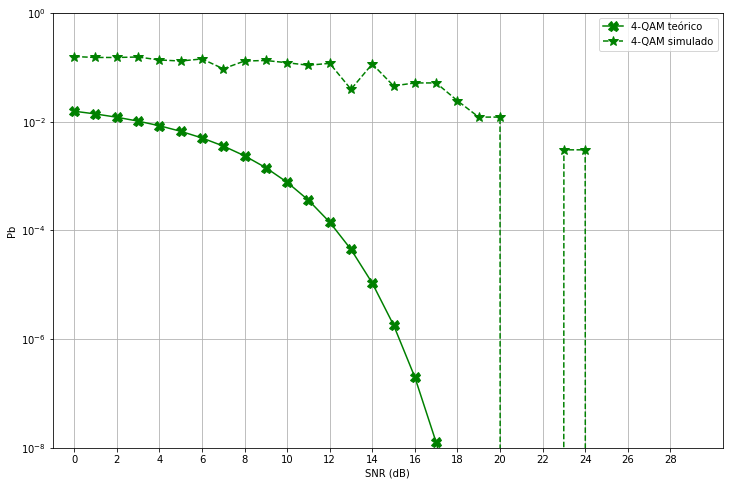

In [28]:
#     # ----------- PLOT ------------
# print(BER)
plt.figure(figsize=(12,8))
plt.plot(SNR, P, 'g', label = '4-QAM teórico', marker = "X", markersize = 10)
plt.plot(SNR, BER, 'g--', label = '4-QAM simulado', marker = "*", markersize = 10)
plt.legend(fontsize = 10)
plt.xlabel('SNR (dB)')
plt.xticks(np.arange(0,30,2))
plt.xlim(-1)
plt.ylabel('Pb');
plt.ylim(1e-8, 1)
plt.yscale('log')
plt.grid(True);

In [17]:
# OFDM_TX = OFDM_withCP  
# OFDM_RX = channel(OFDM_TX, 'awgn', SNR_db)

# plt.plot(abs(OFDM_TX), label = 'TX signal')
# plt.plot(abs(OFDM_RX), label = 'RX signal')
# plt.legend(fontsize = 10)
# plt.xlabel('Time'); plt.ylabel('$|x(t)|$');
# plt.grid(True);

### Retirar CP do símbolo OFDM na recepção

In [18]:
# OFDM_RX_noCP = removeCP(OFDM_RX)
# print(OFDM_RX_noCP)

### Transformada de Fourier dos símbolos OFDM na recepção do sistema

In [19]:
# OFDM_demod = DFT(OFDM_RX_noCP)
# print(OFDM_demod)

### Estimação do canal

In [20]:
# Hest = channelEstimate(OFDM_demod)

### Equalização do canal

In [21]:
# equalized_Hest = equalize(OFDM_demod, Hest)
# print(equalized_Hest)

### Símbolos OFDM de subportadoras de dados

In [22]:
# QAM_est = get_payload(equalized_Hest)

# plt.plot(QAM_est.real, QAM_est.imag, 'bo');
# plt.grid(True)

### Demapeamento

In [23]:
# demapping_table = {v : k for k, v in mapping_table.items()}
# print(demapping_table)
# print(len(demapping_table))

In [24]:
# PS_est, hardDecision = Demapping(QAM_est)
# for qam, hard in zip(QAM_est, hardDecision):
#     plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-o');
#     plt.plot(hardDecision.real, hardDecision.imag, 'ro')
#     plt.grid(True)

### Avaliação de desempenho do sistema

In [25]:
# bits_est = PS_est.reshape((-1,))

# erro = 0
# i = 0

# for b in bits_SP:    
#     c = np.array_str(b)
#     c = c.translate({ord('['):None,ord(']'):None,ord(' '):None})
#     if bits_est[i] != c:
#         erro += 1
#     i += 1

# bit_error = erro/len(bits_SP)
# print ("Obtained total Bit error rate: {:.8f}".format(bit_error))

In [26]:
# Ps = []
# snr_db = []
# # bits_wrong = []
# # BER = []

# for snr in np.arange(0, 30, 2):

#     Ps.append(prob_symb_error(snr, mu))
#     snr_db.append(snr)
# #     bits_wrong = error_estimation(bits_SP, bits_est)
# #     BER.append(bits_wrong/total_bits)

# plt.figure(figsize = (8,8))
# plt.plot(snr_db, Ps, label = 'Symbol error rate (Ps) vs. SNR (dB)')
# plt.legend(fontsize = 10)
# plt.xlabel('SNR (dB)');
# plt.xticks(snr_db)
# plt.xlim(-2)
# plt.ylabel('Ps');
# plt.yscale('log')
# plt.grid(True);